In [1]:
import io
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary
import torchvision.models as models

In [2]:
def clear():
    gc.collect()
    torch.cuda.empty_cache()
def memory():
    allocated_memory = torch.cuda.memory_allocated()
    cached_memory = torch.cuda.memory_reserved()
    print(f"Allocated Memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Cached Memory: {cached_memory / (1024 ** 3):.2f} GB")

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
if torch.cuda.is_available():
  torch.set_default_device('cuda')
  device = 'cuda'
else:
  device = 'cpu'

In [4]:
fromfile = False
if fromfile:
    df = pd.read_parquet('dataset1', engine='fastparquet')
    shuffled_df = df[['image.bytes', 'country_iso_alpha2']].sample(frac=1)
    shuffled_df.to_parquet('shuffled_data.parquet')
df = pd.read_parquet('shuffled_data.parquet', engine='fastparquet')

In [5]:
cntry_str = np.unique(df['country_iso_alpha2'].values); cntry_str.sort()
cntry_dict = dict(zip(cntry_str, range(cntry_str.shape[0])))
with open('cntry_codes_to_names.txt') as f: 
    country_codes = json.loads(f.read())
num_classes = cntry_str.shape[0]

In [6]:
class ParquetImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(io.BytesIO(row['image.bytes']))
        if self.transforms:
            image = self.transforms(image)
        return image.to(device), np.searchsorted(cntry_str, row['country_iso_alpha2'])

class JpgImageDataset(torch.utils.data.Dataset):
    def __init__(self, lst, transforms=None):
        self.lst = lst
        self.transforms = transforms

    def __len__(self):
        return len(self.lst)

    def __getitem__(self, idx):
        row = self.lst[idx]
        image = Image.open(row[0])
        if self.transforms:
            image = self.transforms(image)
        return image.to(device), row[1]

In [7]:
batch_size = 16
im_height = 512

im_width = int(im_height * (1536 / 662))

transf = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

parquet_dataset = ParquetImageDataset(df, transforms.Compose([transforms.RandomCrop((im_height, im_width)), transf]))

imfolder = torchvision.datasets.ImageFolder.make_dataset(directory="dataset2", is_valid_file=(lambda s: Image.open(s).size == (1536, 662)), class_to_idx=cntry_dict)
jpg_dataset = JpgImageDataset(imfolder, transforms=transforms.Compose([transforms.Resize(im_height), transf]))

big_dataset = torch.utils.data.ConcatDataset([jpg_dataset, parquet_dataset])

# datasets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(big_dataset, [0.7, 0.2, 0.1], generator=torch.Generator('cuda'))

# dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, generator=torch.Generator('cuda'))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=True, generator=torch.Generator('cuda'))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=True, generator=torch.Generator('cuda'))

In [8]:
def show_examples(loader, n, model=None):
    for  images, labels in loader:
        if n <= batch_size:
            for i in range(n):
                print(f'label: {country_codes[cntry_str[labels[i]]]}')
                if model != None:
                        print(f'guess: {country_codes[cntry_str[torch.argmax(model(images[i][None, :])).item()]]}')
                plt.figure(figsize = (50,2))
                plt.imshow(images[i].to('cpu').transpose(0,2).transpose(0,1) * 0.5 + 0.5)
                plt.show()
        else:
            print(f"Number of images ({n}) should be less than or equal to batch size ({batch_size})")
        break # next(iter(loader)) esetén "list object is not callable" error jön

Dataset size: 34427

-Examples:
label: Ireland


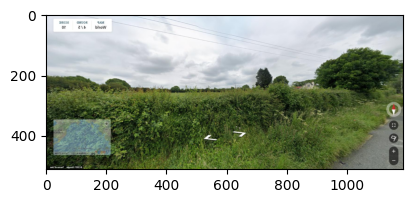

label: Hungary


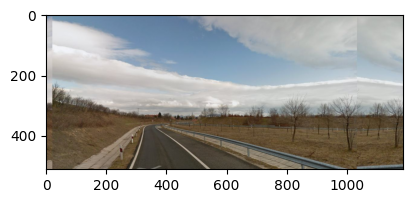

label: Poland


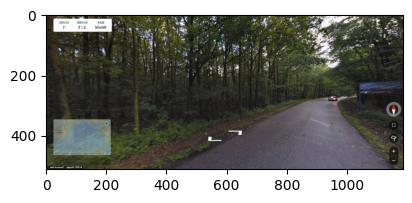

In [9]:
print(f"Dataset size: {len(big_dataset)}\n\n-Examples:")
show_examples(val_dataloader, 3)

In [10]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(nn.Linear(num_ftrs, 1000),
                                         nn.Linear(1000, 300),
                                         nn.Linear(300, num_classes))

    def forward(self, x):
        return self.backbone(x)

    @torch.no_grad()
    def calc_loss_and_acc(self, dataloader, n=float('inf') , conf=False, criterion=nn.CrossEntropyLoss()):
        self.eval()
        
        targets_long = torch.tensor([])
        preds = torch.tensor([])
        loss_sum = 0.0
        acc_sum = 0

        for i, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = self(inputs)
            
            loss_sum += criterion(outputs, targets).item()
            acc_sum += torch.sum(torch.argmax(outputs, 1) == targets)

            if conf:
                targets_long = torch.cat((targets_long, targets))
                preds = torch.cat((preds, torch.argmax(outputs, 1)))

            if i >= n: break
        
        if conf:
            targets_long = F.one_hot(input=targets_long.long(), num_classes=56).transpose(0,1)[:, None, :]
            preds = F.one_hot(preds.long()).transpose(0,1)[None, ...]
            # targets: (56, 1, n)
            # preds:  (1, 56, n)

            hm = torch.sum(torch.logical_and(targets_long, preds), axis=2).to('cpu')
            hm = hm / torch.sum(hm, dim=1, keepdim=True)
            plt.figure(figsize = (8, 8))
            plt.imshow(hm, cmap='copper')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.locator_params(axis='both', integer=True)
            plt.show()

        if n == float('inf'):
            n = len(dataloader)
            
        return loss_sum / n, acc_sum / (n * batch_size)

    def get_loss(self, batch, criterion=nn.CrossEntropyLoss()):
        inputs, labels = batch
        return criterion(self(inputs), labels)

In [11]:
model = Model().to(device)

In [12]:
for param in model.backbone.parameters():
        param.requires_grad = False
for param in model.backbone.fc.parameters():
        param.requires_grad = True
for param in model.backbone.layer4.parameters():
        param.requires_grad = True

In [13]:
torchsummary.summary(model, (3, im_height, im_width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 594]           9,408
       BatchNorm2d-2         [-1, 64, 256, 594]             128
              ReLU-3         [-1, 64, 256, 594]               0
         MaxPool2d-4         [-1, 64, 128, 297]               0
            Conv2d-5         [-1, 64, 128, 297]           4,096
       BatchNorm2d-6         [-1, 64, 128, 297]             128
              ReLU-7         [-1, 64, 128, 297]               0
            Conv2d-8         [-1, 64, 128, 297]          36,864
       BatchNorm2d-9         [-1, 64, 128, 297]             128
             ReLU-10         [-1, 64, 128, 297]               0
           Conv2d-11        [-1, 256, 128, 297]          16,384
      BatchNorm2d-12        [-1, 256, 128, 297]             512
           Conv2d-13        [-1, 256, 128, 297]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [14]:
tr_losses = []
val_losses = []

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [22]:
num_epochs = 1

for epoch in range(num_epochs):
  for i, batch in enumerate(train_dataloader):
    model.train()
    optimizer.zero_grad()

    train_loss = model.get_loss(batch)
    train_loss.backward()
    optimizer.step()

    if i % 40 == 0:                                                                                                         
      tr_losses.append(train_loss.item())
      val_loss, acc = model.calc_loss_and_acc(val_dataloader, 10)
      val_losses.append(val_loss)
      print(f"epoch {epoch}, step {i}: train loss {train_loss:.4f}, val loss: {val_loss:.4f}, val acc: {acc:.4f}")


epoch 0, step 0: train loss 2.1239, val loss: 2.2721, val acc: 0.4875
epoch 0, step 40: train loss 2.0966, val loss: 2.5874, val acc: 0.4500
epoch 0, step 80: train loss 1.7195, val loss: 2.0746, val acc: 0.5000
epoch 0, step 120: train loss 2.3116, val loss: 2.4128, val acc: 0.4375
epoch 0, step 160: train loss 1.4226, val loss: 2.2164, val acc: 0.5312
epoch 0, step 200: train loss 1.9789, val loss: 2.1495, val acc: 0.5375
epoch 0, step 240: train loss 1.9223, val loss: 1.8700, val acc: 0.5500
epoch 0, step 280: train loss 2.2276, val loss: 2.0623, val acc: 0.4813
epoch 0, step 320: train loss 1.5248, val loss: 2.1439, val acc: 0.5312
epoch 0, step 360: train loss 1.7946, val loss: 2.2143, val acc: 0.5500
epoch 0, step 400: train loss 1.6594, val loss: 2.0541, val acc: 0.5500
epoch 0, step 440: train loss 2.1234, val loss: 1.9365, val acc: 0.5125
epoch 0, step 480: train loss 2.1445, val loss: 2.0712, val acc: 0.5188
epoch 0, step 520: train loss 2.0432, val loss: 2.1902, val acc: 0.4

KeyboardInterrupt: 

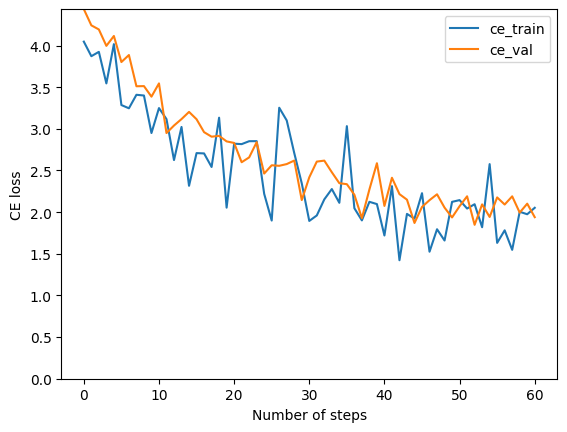

In [23]:
plt.plot(tr_losses, label="ce_train")
plt.plot(val_losses, label="ce_val")
plt.xlabel("Number of steps")
plt.ylabel("CE loss")
plt.ylim(0, np.max(val_losses))
plt.legend()
plt.show()

In [18]:
#torch.save(model.state_dict(), "models/")

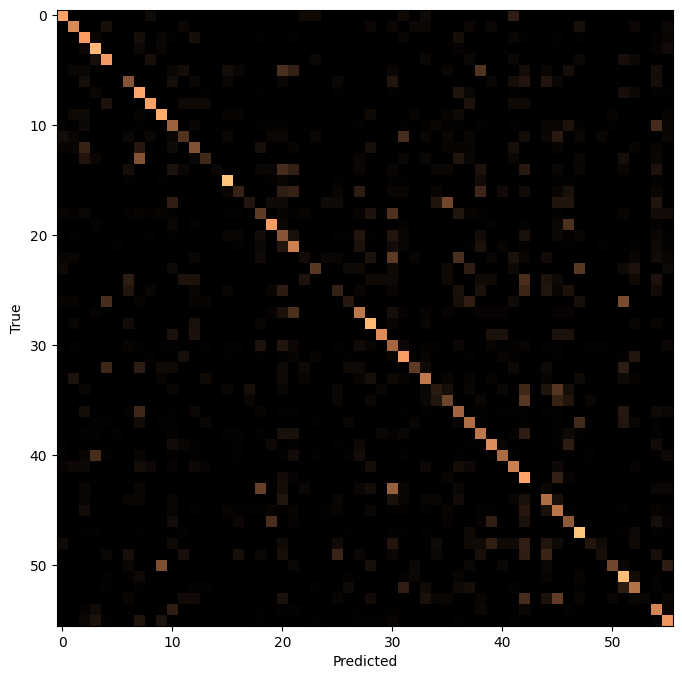

(1.884012432286033, tensor(0.4653, device='cuda:0'))

In [24]:
clear()
model.calc_loss_and_acc(test_dataloader, conf=True)

label: Russia
guess: Russia


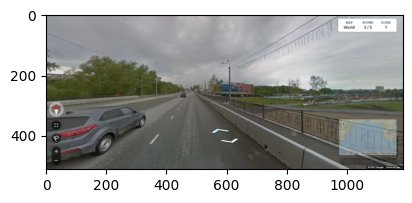

label: Poland
guess: Poland


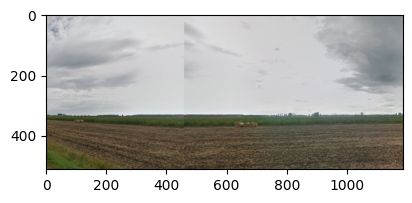

label: Norway
guess: Australia


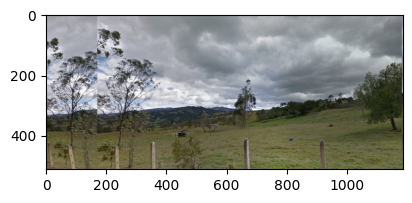

label: United Kingdom
guess: United Kingdom


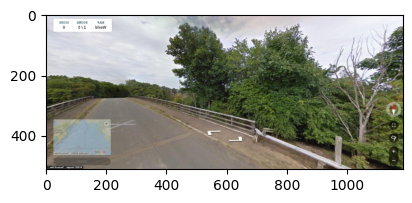

label: Thailand
guess: Thailand


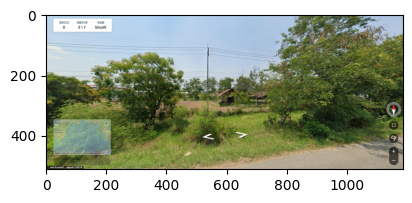

label: United States
guess: United States


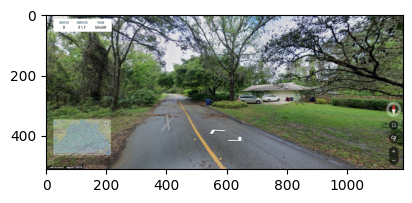

label: Denmark
guess: Netherlands


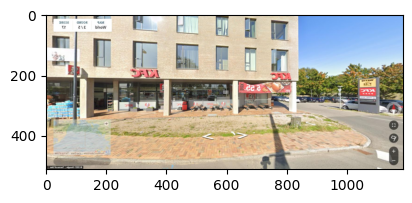

label: Netherlands
guess: United Kingdom


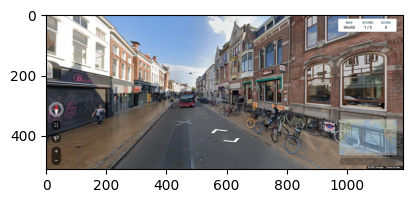

label: Japan
guess: Japan


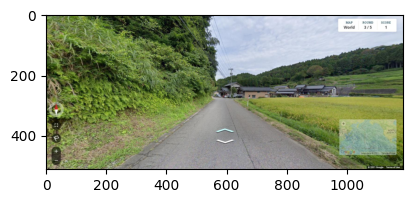

label: Spain
guess: France


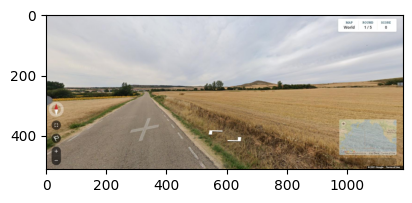

In [25]:
show_examples(test_dataloader, 10, model)